In [1]:
import pynbody
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pynbody import units
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from scipy import stats
from scipy import constants
import pynbody.filt as f
import matplotlib.gridspec as gd
import pickle


In [6]:
pynbody.config["number_of_threads"] = 2
pynbody.config["sph"]["Kernel"] = 'WendlandC2'
pynbody.config['sph']['smooth-particles'] = 50

In [ ]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def vel_div(self):
    import logging
    logger = logging.getLogger('pynbody.sph')

    pynbody.sph.build_tree(self)

    logger.info('Calculating velocity divergence')
    
    vel_div = self.kdtree.sph_divergence(self['vel'], nsmooth=pynbody.config['sph']['smooth-particles'])


    return vel_div

In [60]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def rho_W_25(self):
    pynbody.sph.build_tree_or_trees(self)


    rho = pynbody.array.SimArray(
        np.empty(len(self['pos'])), self['mass'].units / self['pos'].units ** 3,
        dtype=self['pos'].dtype)



    self.kdtree.set_array_ref('smooth',pynbody.sph._get_smooth_array_ensuring_compatibility(self))
    self.kdtree.set_array_ref('mass',self['mass'])
    self.kdtree.set_array_ref('rho',rho)

    self.kdtree.populate('rho', 25, 'WendlandC2')

    return rho

@pynbody.snapshot.SimSnap.stable_derived_quantity
def rho_W_50(self):
    pynbody.sph.build_tree_or_trees(self)


    rho = pynbody.array.SimArray(
        np.empty(len(self['pos'])), self['mass'].units / self['pos'].units ** 3,
        dtype=self['pos'].dtype)



    self.kdtree.set_array_ref('smooth',pynbody.sph._get_smooth_array_ensuring_compatibility(self))
    self.kdtree.set_array_ref('mass',self['mass'])
    self.kdtree.set_array_ref('rho',rho)

    self.kdtree.populate('rho', 50, 'WendlandC2')

    return rho

@pynbody.snapshot.SimSnap.stable_derived_quantity
def rho_W_100(self):
    pynbody.sph.build_tree_or_trees(self)


    rho = pynbody.array.SimArray(
        np.empty(len(self['pos'])), self['mass'].units / self['pos'].units ** 3,
        dtype=self['pos'].dtype)



    self.kdtree.set_array_ref('smooth',pynbody.sph._get_smooth_array_ensuring_compatibility(self))
    self.kdtree.set_array_ref('mass',self['mass'])
    self.kdtree.set_array_ref('rho',rho)

    self.kdtree.populate('rho', 100, 'WendlandC2')

    return rho

@pynbody.snapshot.SimSnap.stable_derived_quantity
def rho_W_1000(self):
    pynbody.sph.build_tree_or_trees(self)


    rho = pynbody.array.SimArray(
        np.empty(len(self['pos'])), self['mass'].units / self['pos'].units ** 3,
        dtype=self['pos'].dtype)



    self.kdtree.set_array_ref('smooth',pynbody.sph._get_smooth_array_ensuring_compatibility(self))
    self.kdtree.set_array_ref('mass',self['mass'])
    self.kdtree.set_array_ref('rho',rho)

    self.kdtree.populate('rho', 1000, 'WendlandC2')

    return rho

@pynbody.snapshot.SimSnap.stable_derived_quantity
def rho_CS_25(self):
    pynbody.sph.build_tree_or_trees(self)


    rho = pynbody.array.SimArray(
        np.empty(len(self['pos'])), self['mass'].units / self['pos'].units ** 3,
        dtype=self['pos'].dtype)



    self.kdtree.set_array_ref('smooth',pynbody.sph._get_smooth_array_ensuring_compatibility(self))
    self.kdtree.set_array_ref('mass',self['mass'])
    self.kdtree.set_array_ref('rho',rho)

    self.kdtree.populate('rho', 25, 'CubicSpline')

    return rho

@pynbody.snapshot.SimSnap.stable_derived_quantity
def rho_CS_50(self):
    pynbody.sph.build_tree_or_trees(self)


    rho = pynbody.array.SimArray(
        np.empty(len(self['pos'])), self['mass'].units / self['pos'].units ** 3,
        dtype=self['pos'].dtype)



    self.kdtree.set_array_ref('smooth',pynbody.sph._get_smooth_array_ensuring_compatibility(self))
    self.kdtree.set_array_ref('mass',self['mass'])
    self.kdtree.set_array_ref('rho',rho)

    self.kdtree.populate('rho', 50, 'CubicSpline')

    return rho

@pynbody.snapshot.SimSnap.stable_derived_quantity
def rho_CS_100(self):
    pynbody.sph.build_tree_or_trees(self)


    rho = pynbody.array.SimArray(
        np.empty(len(self['pos'])), self['mass'].units / self['pos'].units ** 3,
        dtype=self['pos'].dtype)



    self.kdtree.set_array_ref('smooth',pynbody.sph._get_smooth_array_ensuring_compatibility(self))
    self.kdtree.set_array_ref('mass',self['mass'])
    self.kdtree.set_array_ref('rho',rho)

    self.kdtree.populate('rho', 100, 'CubicSpline')

    return rho

In [7]:
pynbody.config['sph']['smooth-particles']
pynbody.config["sph"]["Kernel"]

'WendlandC2'

In [8]:
s = pynbody.load('../Documents/Bachelorthesis/simulations/g8.26/g8.26e11.01024')
h = s.halos()
h1 = h[1]
s.physical_units()
pynbody.analysis.angmom.faceon(h1)

In [30]:
s.g['rho_W']

SimArray([0.00417549, 0.02533851, 0.06294318, ..., 0.06326283, 0.02665569,
          0.0154375 ], 'Msol kpc**-3')

In [31]:
s.g['rho']

SimArray([0.00408032, 0.02491777, 0.06223683, ..., 0.06228387, 0.02613925,
          0.01511545], 'Msol kpc**-3')

In [39]:
disk = f.LowPass('r', '72 kpc') & f.BandPass('z', '-0.5 kpc', '0.5 kpc')
gal = h1[disk]

In [6]:
s.g['v_div']

SimArray([0.0066882 , 0.01525597, 0.01627594, ..., 0.02011026, 0.01703488,
          0.01207644], 'km s**-1 kpc**-1')

In [40]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def mass_sph(self):
    import logging
    logger = logging.getLogger('pynbody.sph')

    pynbody.sph.build_tree_or_trees(self)

    logger.info('Calculating sph mean')
    
    mass_sph = self.kdtree.sph_mean(self['mass'], nsmooth=pynbody.config['sph']['smooth-particles'])
    

    return mass_sph

@pynbody.snapshot.SimSnap.derived_quantity
def v_curl2(self):
    """Squared velocity"""
    return (self['v_curl'] ** 2).sum(axis=1)

# mass weighted 2d histograms

def mw_hist2(fam, key, b):
    hist, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam[key]*fam['mass'], bins=b, range=((-50,50),(-50,50)))
    mass, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam['mass'], bins=b, range=((-50,50),(-50,50)))
    return hist/mass

def mw_hist(fam, array, b):
    hist, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=array*fam['mass'], bins=b, range=((-50,50),(-50,50)))
    mass, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam['mass'], bins=b, range=((-50,50),(-50,50)))
    return hist/mass

In [8]:
# calculations
'''
disk = f.LowPass('r', '72 kpc') & f.BandPass('z', '-0.5 kpc', '0.5 kpc')
(10*1.673*10**(-27)*units.kg/units.cm**3).ratio(units.Msol/units.kpc**3)
#sf = f.HighPass('rho', '247133368.31459114 Msol kpc^-3') & f.LowPass('temp', '30000 K')
gal = h1[disk]
gal.g['rho']
gal.g['rho']
gal.s['rho']
gal.g['v_div']
gal.s['v_div']
gal.g['v_curl']
gal.s['v_curl']
gal.g['mass_sph']
gal.s['mass_sph']
gal.g['v_curl2']
gal.s['v_curl2']
m_part = gal.g['mass']
m_kern = gal.g['rho']*4/3*np.pi*gal.g['smooth']**3 
m_sph = gal.g['mass_sph']

gal.g['radius'] = gal.g['smooth'].in_units('m') #in units m
gal.g['radius_2'] = gal.g['radius']
gal.g['radius_2'] = (m_sph.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)
gal.g['radius_3'] = gal.g['radius']
gal.g['radius_3'] = (m_part.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)

gal.g['alpha'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_sph.in_units('kg'))).in_units(1)
gal.g['alpha_2'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius_2']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_sph.in_units('kg'))).in_units(1)
gal.g['alpha_3'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius_3']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_part.in_units('kg'))).in_units(1)
gal.g['alpha_4'] = 1/4*(np.abs(gal.g['v_div'].in_units('s**-1'))**2+np.sqrt(gal.g['v_curl2'].in_units('s**-2'))**2)/(constants.G*units.m**3*units.kg**-1*gal.g['rho'].in_units('kg m**-3')).in_units(1)
#gal.g['alpha_5'] = # mit Ekin und Epot

b = 2.02
gal.g['efficiency'] = np.exp(-b*gal.g['alpha_4']**(1/2))

low_alpha = f.LowPass('alpha', '100')
low_alpha_2 = f.LowPass('alpha_2', '100')
low_alpha_3 = f.LowPass('alpha_3', '100')
low_alpha_4 = f.LowPass('alpha_4', '100')

gal_low_alpha = gal.g[low_alpha]
gal_low_alpha_2 = gal.g[low_alpha_2]
gal_low_alpha_3 = gal.g[low_alpha_3]
gal_low_alpha_4 = gal.g[low_alpha_4]
'''
    

"\ndisk = f.LowPass('r', '72 kpc') & f.BandPass('z', '-0.5 kpc', '0.5 kpc')\n(10*1.673*10**(-27)*units.kg/units.cm**3).ratio(units.Msol/units.kpc**3)\n#sf = f.HighPass('rho', '247133368.31459114 Msol kpc^-3') & f.LowPass('temp', '30000 K')\ngal = h1[disk]\ngal.g['rho']\ngal.g['rho']\ngal.s['rho']\ngal.g['v_div']\ngal.s['v_div']\ngal.g['v_curl']\ngal.s['v_curl']\ngal.g['mass_sph']\ngal.s['mass_sph']\ngal.g['v_curl2']\ngal.s['v_curl2']\nm_part = gal.g['mass']\nm_kern = gal.g['rho']*4/3*np.pi*gal.g['smooth']**3 \nm_sph = gal.g['mass_sph']\n\ngal.g['radius'] = gal.g['smooth'].in_units('m') #in units m\ngal.g['radius_2'] = gal.g['radius']\ngal.g['radius_2'] = (m_sph.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)\ngal.g['radius_3'] = gal.g['radius']\ngal.g['radius_3'] = (m_part.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)\n\ngal.g['alpha'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius']/(3*constants.G*units.m**3*units.kg**

In [9]:
'''
# pickling
with open('CS_100.pkl', 'wb') as CS_100_pickle:
    pickle.dump(gal.g['rho'], CS_100_pickle)
    pickle.dump(gal.g['v_div'], CS_100_pickle)
    pickle.dump(gal.g['v_curl'], CS_100_pickle)
    pickle.dump(gal.g['mass_sph'], CS_100_pickle)
    pickle.dump(gal.g['v_curl2'], CS_100_pickle)
    pickle.dump(gal.g['v_disp'], CS_100_pickle)
    pickle.dump(gal.g['mass'], CS_100_pickle)
    pickle.dump(gal.g['smooth'], CS_100_pickle) 
    pickle.dump(gal.g['radius'], CS_100_pickle)
    pickle.dump(gal.g['radius_2'], CS_100_pickle)
    pickle.dump(gal.g['radius_3'], CS_100_pickle)   
    pickle.dump(gal.g['alpha'], CS_100_pickle)
    pickle.dump(gal.g['alpha_2'], CS_100_pickle)
    pickle.dump(gal.g['alpha_3'], CS_100_pickle)
    pickle.dump(gal.g['alpha_4'], CS_100_pickle)
    pickle.dump(gal.g['efficiency'], CS_100_pickle)
    '''

"\n# pickling\nwith open('CS_100.pkl', 'wb') as CS_100_pickle:\n    pickle.dump(gal.g['rho'], CS_100_pickle)\n    pickle.dump(gal.g['v_div'], CS_100_pickle)\n    pickle.dump(gal.g['v_curl'], CS_100_pickle)\n    pickle.dump(gal.g['mass_sph'], CS_100_pickle)\n    pickle.dump(gal.g['v_curl2'], CS_100_pickle)\n    pickle.dump(gal.g['v_disp'], CS_100_pickle)\n    pickle.dump(gal.g['mass'], CS_100_pickle)\n    pickle.dump(gal.g['smooth'], CS_100_pickle) \n    pickle.dump(gal.g['radius'], CS_100_pickle)\n    pickle.dump(gal.g['radius_2'], CS_100_pickle)\n    pickle.dump(gal.g['radius_3'], CS_100_pickle)   \n    pickle.dump(gal.g['alpha'], CS_100_pickle)\n    pickle.dump(gal.g['alpha_2'], CS_100_pickle)\n    pickle.dump(gal.g['alpha_3'], CS_100_pickle)\n    pickle.dump(gal.g['alpha_4'], CS_100_pickle)\n    pickle.dump(gal.g['efficiency'], CS_100_pickle)\n"

In [41]:
# unpickling CS_25
with open('CS_25.pkl', 'rb') as CS_25_pickle:
    rho_CS_25 = pickle.load(CS_25_pickle)
    vdiv_CS_25 = pickle.load(CS_25_pickle)
    vcurl_CS_25 = pickle.load(CS_25_pickle)
    sphmass_CS_25 = pickle.load(CS_25_pickle)
    vcurl2_CS_25 = pickle.load(CS_25_pickle)
    vdisp_CS_25 = pickle.load(CS_25_pickle)
    mass_CS_25 = pickle.load(CS_25_pickle)
    smooth_CS_25 = pickle.load(CS_25_pickle) 
    radius_CS_25 = pickle.load(CS_25_pickle)
    radius2_CS_25 = pickle.load(CS_25_pickle)
    radius3_CS_25 = pickle.load(CS_25_pickle)   
    alpha_CS_25 = pickle.load(CS_25_pickle)
    alpha2_CS_25 = pickle.load(CS_25_pickle)
    alpha3_CS_25 = pickle.load(CS_25_pickle)
    alpha4_CS_25 = pickle.load(CS_25_pickle)
    eff_CS_25 = pickle.load(CS_25_pickle)


In [42]:

# unpickling
with open('CS_50.pkl', 'rb') as CS_50_pickle:
    rho_CS_50 = pickle.load(CS_50_pickle)
    vdiv_CS_50 = pickle.load(CS_50_pickle)
    vcurl_CS_50 = pickle.load(CS_50_pickle)
    sphmass_CS_50 = pickle.load(CS_50_pickle)
    vcurl2_CS_50 = pickle.load(CS_50_pickle)
    vdisp_CS_50 = pickle.load(CS_50_pickle)
    mass_CS_50 = pickle.load(CS_50_pickle)
    smooth_CS_50 = pickle.load(CS_50_pickle) 
    radius_CS_50 = pickle.load(CS_50_pickle)
    radius2_CS_50 = pickle.load(CS_50_pickle)
    radius3_CS_50 = pickle.load(CS_50_pickle)   
    alpha_CS_50 = pickle.load(CS_50_pickle)
    alpha2_CS_50 = pickle.load(CS_50_pickle)
    alpha3_CS_50 = pickle.load(CS_50_pickle)
    alpha4_CS_50 = pickle.load(CS_50_pickle)
    eff_CS_50 = pickle.load(CS_50_pickle)
print(alpha_CS_50)

[ 42.37590436 401.87768197 211.98790146 ... 108.16772099 322.64955014
  89.74117225]


In [43]:

# unpickling
with open('CS_100.pkl', 'rb') as CS_100_pickle:
    rho_CS_100 = pickle.load(CS_100_pickle) 
    vdiv_CS_100 = pickle.load(CS_100_pickle)
    vcurl_CS_100 = pickle.load(CS_100_pickle)
    sphmass_CS_100 = pickle.load(CS_100_pickle)
    vcurl2_CS_100 = pickle.load(CS_100_pickle)
    vdisp_CS_100 = pickle.load(CS_100_pickle)
    mass_CS_100 = pickle.load(CS_100_pickle)
    smooth_CS_100 = pickle.load(CS_100_pickle) 
    radius_CS_100 = pickle.load(CS_100_pickle)
    radius2_CS_100 = pickle.load(CS_100_pickle)
    radius3_CS_100 = pickle.load(CS_100_pickle)   
    alpha_CS_100 = pickle.load(CS_100_pickle)
    alpha2_CS_100 = pickle.load(CS_100_pickle)
    alpha3_CS_100 = pickle.load(CS_100_pickle)
    alpha4_CS_100 = pickle.load(CS_100_pickle)
    eff_CS_100 = pickle.load(CS_100_pickle)

In [44]:

# unpickling
with open('W_25.pkl', 'rb') as W_25_pickle:
    rho_W_25 = pickle.load(W_25_pickle) 
    vdiv_W_25 = pickle.load(W_25_pickle)
    vcurl_W_25 = pickle.load(W_25_pickle)
    sphmass_W_25 = pickle.load(W_25_pickle)
    vcurl2_W_25 = pickle.load(W_25_pickle)
    vdisp_W_25 = pickle.load(W_25_pickle)
    mass_W_25 = pickle.load(W_25_pickle)
    smooth_W_25 = pickle.load(W_25_pickle) 
    radius_W_25 = pickle.load(W_25_pickle)
    radius2_W_25 = pickle.load(W_25_pickle)
    radius3_W_25 = pickle.load(W_25_pickle)   
    alpha_W_25 = pickle.load(W_25_pickle)
    alpha2_W_25 = pickle.load(W_25_pickle)
    alpha3_W_25 = pickle.load(W_25_pickle)
    alpha4_W_25 = pickle.load(W_25_pickle)
    eff_W_25 = pickle.load(W_25_pickle)

In [45]:

# unpickling
with open('W_50.pkl', 'rb') as W_50_pickle:
    rho_W_50 = pickle.load(W_50_pickle) #überall variablen namen geben
    vdiv_W_50 = pickle.load(W_50_pickle)
    vcurl_W_50 = pickle.load(W_50_pickle)
    sphmass_W_50 = pickle.load(W_50_pickle)
    vcurl2_W_50 = pickle.load(W_50_pickle)
    vdisp_W_50 = pickle.load(W_50_pickle)
    mass_W_50 = pickle.load(W_50_pickle)
    smooth_W_50 = pickle.load(W_50_pickle) 
    radius_W_50 = pickle.load(W_50_pickle)
    radius2_W_50 = pickle.load(W_50_pickle)
    radius3_W_50 = pickle.load(W_50_pickle)   
    alpha_W_50 = pickle.load(W_50_pickle)
    alpha2_W_50 = pickle.load(W_50_pickle)
    alpha3_W_50 = pickle.load(W_50_pickle)
    alpha4_W_50 = pickle.load(W_50_pickle)
    eff_W_50 = pickle.load(W_50_pickle)

In [46]:

# unpickling
with open('W_100.pkl', 'rb') as W_100_pickle:
    rho_W_100 = pickle.load(W_100_pickle) #überall variablen namen geben
    vdiv_W_100 = pickle.load(W_100_pickle)
    vcurl_W_100 = pickle.load(W_100_pickle)
    sphmass_W_100 = pickle.load(W_100_pickle)
    vcurl2_W_100 = pickle.load(W_100_pickle)
    vdisp_W_100 = pickle.load(W_100_pickle)
    mass_W_100 = pickle.load(W_100_pickle)
    smooth_W_100 = pickle.load(W_100_pickle) 
    radius_W_100 = pickle.load(W_100_pickle)
    radius2_W_100 = pickle.load(W_100_pickle)
    radius3_W_100 = pickle.load(W_100_pickle)   
    alpha_W_100 = pickle.load(W_100_pickle)
    alpha2_W_100 = pickle.load(W_100_pickle)
    alpha3_W_100 = pickle.load(W_100_pickle)
    alpha4_W_100 = pickle.load(W_100_pickle)
    eff_W_100 = pickle.load(W_100_pickle)

In [61]:
print(gal.g['rho_W_1000'])

[31530559.03991144 57207110.27247659 12505516.18411783 ...
 81177162.22545688 74199268.82677269 69436245.58652507]


In [51]:
print(gal.g['rho_CS_25'])
print(gal.g['rho_CS_50'])
print(gal.g['rho_CS_100'])
print(gal.g['rho_W_25'])
print(gal.g['rho_W_50'])
print(gal.g['rho_W_100'])

[30052466.08356311 56834898.98089549 11840345.27625312 ...
 78525993.10496804 73963440.07824834 66073631.88897831]
[30052466.08356311 56834898.98089549 11840345.27625312 ...
 78525993.10496804 73963440.07824834 66073631.88897831]
[30052466.08356311 56834898.98089549 11840345.27625312 ...
 78525993.10496804 73963440.07824834 66073631.88897831]
[31530559.03991144 57207110.27247659 12505516.18411783 ...
 81177162.22545688 74199268.82677269 69436245.58652507]
[31530559.03991144 57207110.27247659 12505516.18411783 ...
 81177162.22545688 74199268.82677269 69436245.58652507]
[31530559.03991144 57207110.27247659 12505516.18411783 ...
 81177162.22545688 74199268.82677269 69436245.58652507]


In [48]:
print(alpha_CS_25)
print(alpha_CS_50)
print(alpha_CS_100)
print(alpha_W_25)
print(alpha_W_50)
print(alpha_W_100)

[ 511.09806185  115.09746573 1698.44591827 ...  188.14923685  210.0947685
   58.04718815]
[ 42.37590436 401.87768197 211.98790146 ... 108.16772099 322.64955014
  89.74117225]
[387.82483344 911.85311138 285.91997787 ... 128.87966733 508.37885996
 464.77615038]
[1515.6675196    48.32427363 3411.35227287 ...  476.27534901  116.44684441
  412.2666279 ]
[  9.08115968 294.63967004 494.91419146 ... 152.6643522  278.00774571
  23.1751852 ]
[250.34371823 759.40452351 119.5024883  ... 154.84923692 463.45183233
 342.47898791]


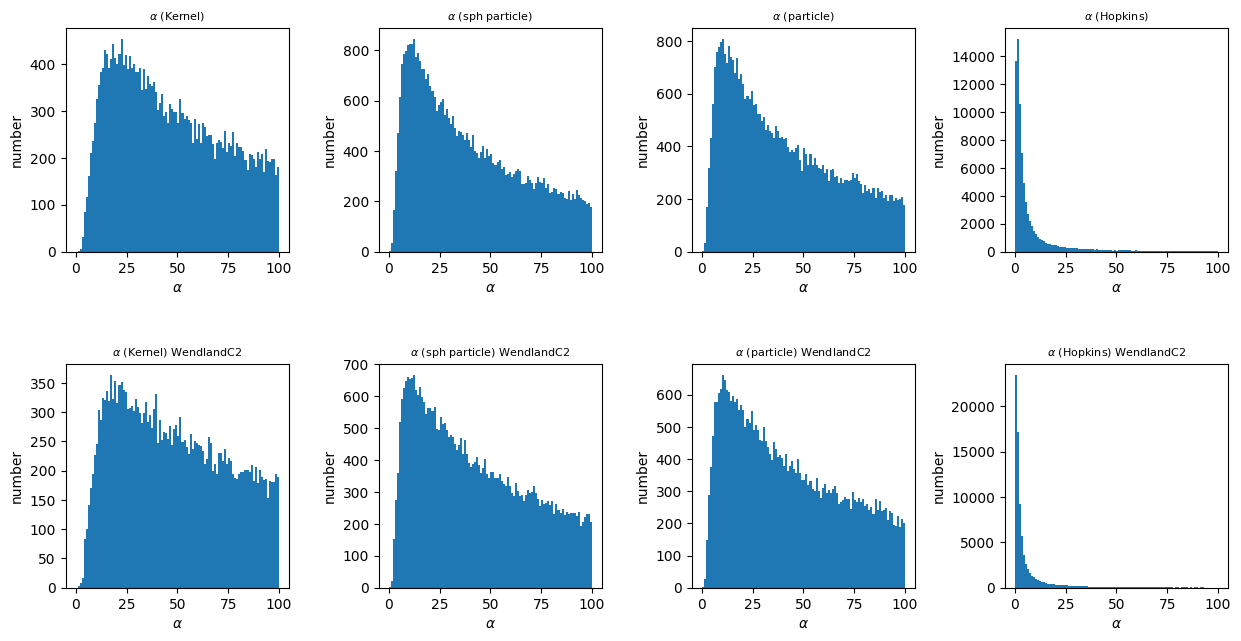

In [49]:
alpha = [alpha_CS_50, alpha2_CS_50, alpha3_CS_50, alpha4_CS_50, alpha_W_50, alpha2_W_50, alpha3_W_50, alpha4_W_50]
title = ['(Kernel)', '(sph particle)', '(particle)', '(Hopkins)']
fig = plt.figure(figsize = (15,8))
gs0 = gd.GridSpec(2, 4, figure=fig, wspace = 0.4)

for n in range(4):
    ax = fig.add_subplot(gs0[n])
    ax.hist(alpha[n], bins = 100, range = (0,100))
    ax.set_title(r'$\alpha$ ' + title[n], wrap = True, fontsize = 8)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('number')
    ax.set_aspect(1./ax.get_data_ratio())
       
for n in range(4,8): 
    ax = fig.add_subplot(gs0[n])
    ax.hist(alpha[n], bins = 100, range = (0,100))
    ax.set_title(r'$\alpha$ ' + title[n-4] + ' WendlandC2', wrap = True, fontsize = 8)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('number')
    ax.set_aspect(1./ax.get_data_ratio())

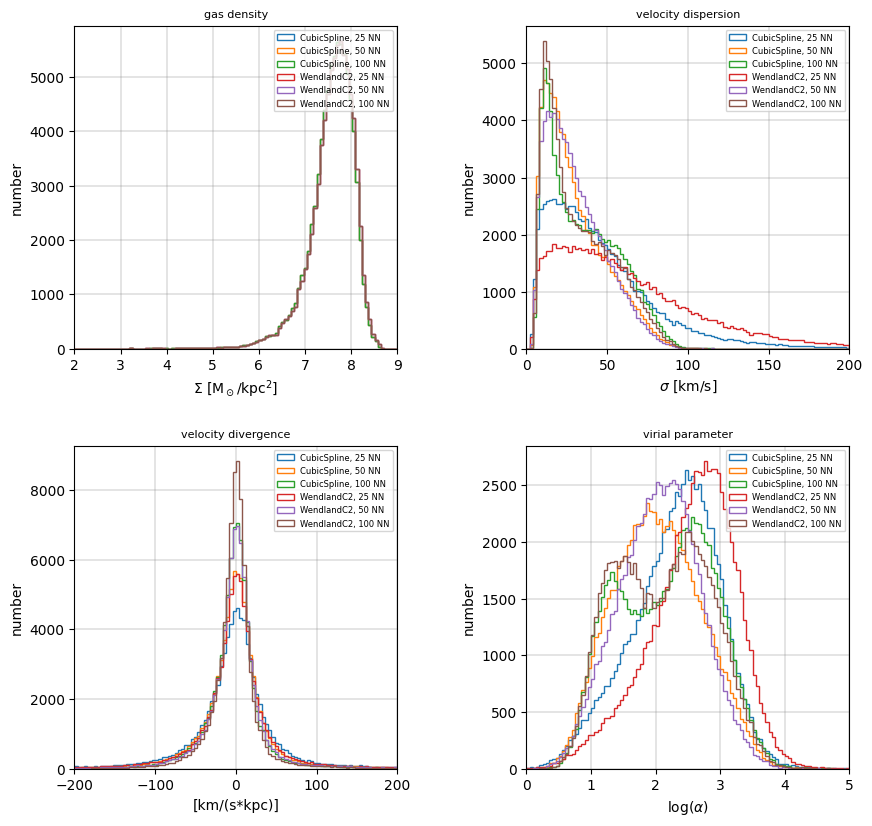

In [64]:
rho_list = [np.log10(gal.g['rho_CS_25']), np.log10(gal.g['rho_CS_50']), np.log10(gal.g['rho_CS_100']), np.log10(gal.g['rho_W_25']), np.log10(gal.g['rho_W_50']), np.log10(gal.g['rho_W_100'])]
v_disp_list = [vdisp_CS_25, vdisp_CS_50, vdisp_CS_100, vdisp_W_25, vdisp_W_50, vdisp_W_100]
v_div_list = [vdiv_CS_25, vdiv_CS_50, vdiv_CS_100, vdiv_W_25, vdiv_W_50, vdiv_W_100]
alpha_2_list = [np.log10(alpha2_CS_25), np.log10(alpha2_CS_50), np.log10(alpha2_CS_100), np.log10(alpha2_W_25), np.log10(alpha2_W_50), np.log10(alpha2_W_100)]
key_list = [rho_list, v_disp_list, v_div_list, alpha_2_list]
range_list = [(2, 9), (0, 200), (-200, 200), (0, 5)]
nn = [25, 50, 100]
title = ['gas density', 'velocity dispersion', 'velocity divergence', 'virial parameter']
unit = [r'$\Sigma$ [M$_\odot$/kpc$^2$]', r'$\sigma$ [km/s]', '[km/(s*kpc)]', 'log('+r'$\alpha$'+')']
label = ['CubicSpline, 25 NN', 'CubicSpline, 50 NN', 'CubicSpline, 100 NN', 'WendlandC2, 25 NN', 'WendlandC2, 50 NN', 'WendlandC2, 100 NN']
fig = plt.figure(figsize = (10,10))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(4):
    ax = fig.add_subplot(gs0[n])
    for i in range(6):
        ax.hist(key_list[n][i], bins = 100, label = label[i], range = range_list[n], histtype = 'step')
        
    ax.set_title(title[n], wrap = True, fontsize = 8)
    ax.set_xlabel(unit[n])
    ax.set_ylabel('number')
    ax.set_xlim(range_list[n])
    ax.set_aspect(1./ax.get_data_ratio())
    ax.grid(linewidth = 0.3, color = 'grey')
    ax.legend(fontsize = 6)

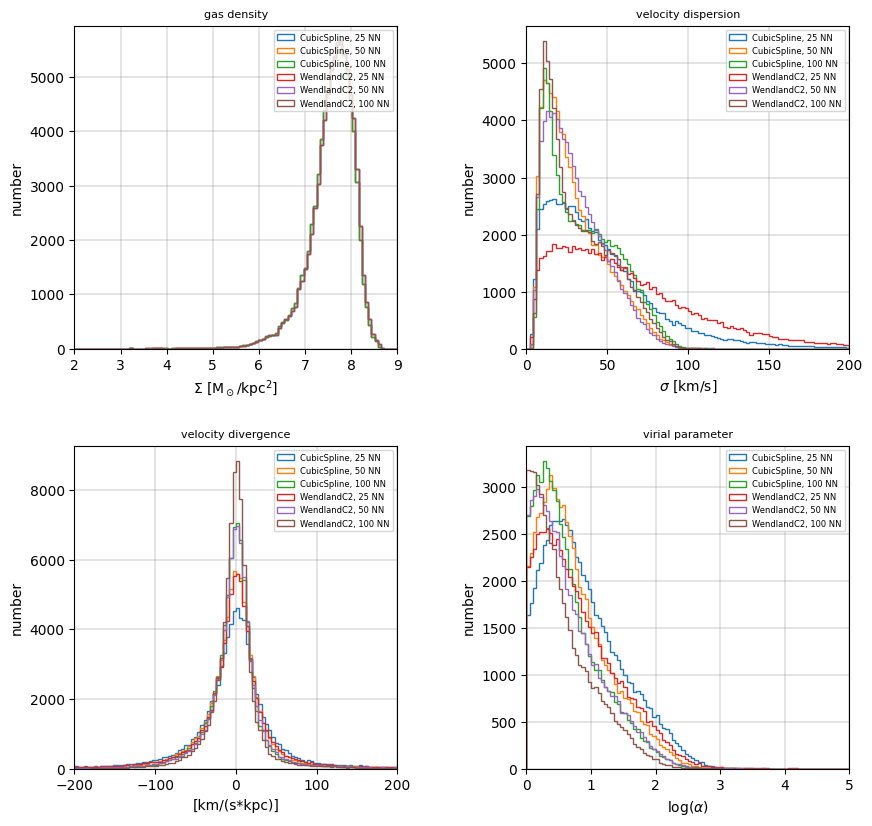

In [63]:
rho_list = [np.log10(gal.g['rho_CS_25']), np.log10(gal.g['rho_CS_50']), np.log10(gal.g['rho_CS_100']), np.log10(gal.g['rho_W_25']), np.log10(gal.g['rho_W_50']), np.log10(gal.g['rho_W_100'])]
v_disp_list = [vdisp_CS_25, vdisp_CS_50, vdisp_CS_100, vdisp_W_25, vdisp_W_50, vdisp_W_100]
v_div_list = [vdiv_CS_25, vdiv_CS_50, vdiv_CS_100, vdiv_W_25, vdiv_W_50, vdiv_W_100]
alpha_4_list = [np.log10(alpha4_CS_25), np.log10(alpha4_CS_50), np.log10(alpha4_CS_100), np.log10(alpha4_W_25), np.log10(alpha4_W_50), np.log10(alpha4_W_100)]
key_list = [rho_list, v_disp_list, v_div_list, alpha_4_list]
range_list = [(2, 9), (0, 200), (-200, 200), (0, 5)]
nn = [25, 50, 100]
title = ['gas density', 'velocity dispersion', 'velocity divergence', 'virial parameter']
unit = [r'$\Sigma$ [M$_\odot$/kpc$^2$]', r'$\sigma$ [km/s]', '[km/(s*kpc)]', 'log('+r'$\alpha$'+')']
label = ['CubicSpline, 25 NN', 'CubicSpline, 50 NN', 'CubicSpline, 100 NN', 'WendlandC2, 25 NN', 'WendlandC2, 50 NN', 'WendlandC2, 100 NN']
fig = plt.figure(figsize = (10,10))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(4):
    ax = fig.add_subplot(gs0[n])
    for i in range(6):
        ax.hist(key_list[n][i], bins = 100, label = label[i], range = range_list[n], histtype = 'step')
        
    ax.set_title(title[n], wrap = True, fontsize = 8)
    ax.set_xlabel(unit[n])
    ax.set_ylabel('number')
    ax.set_xlim(range_list[n])
    ax.set_aspect(1./ax.get_data_ratio())
    ax.grid(linewidth = 0.3, color = 'grey')
    ax.legend(fontsize = 6)

/tmp/ipykernel_9570/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass
/tmp/ipykernel_9570/2743804907.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


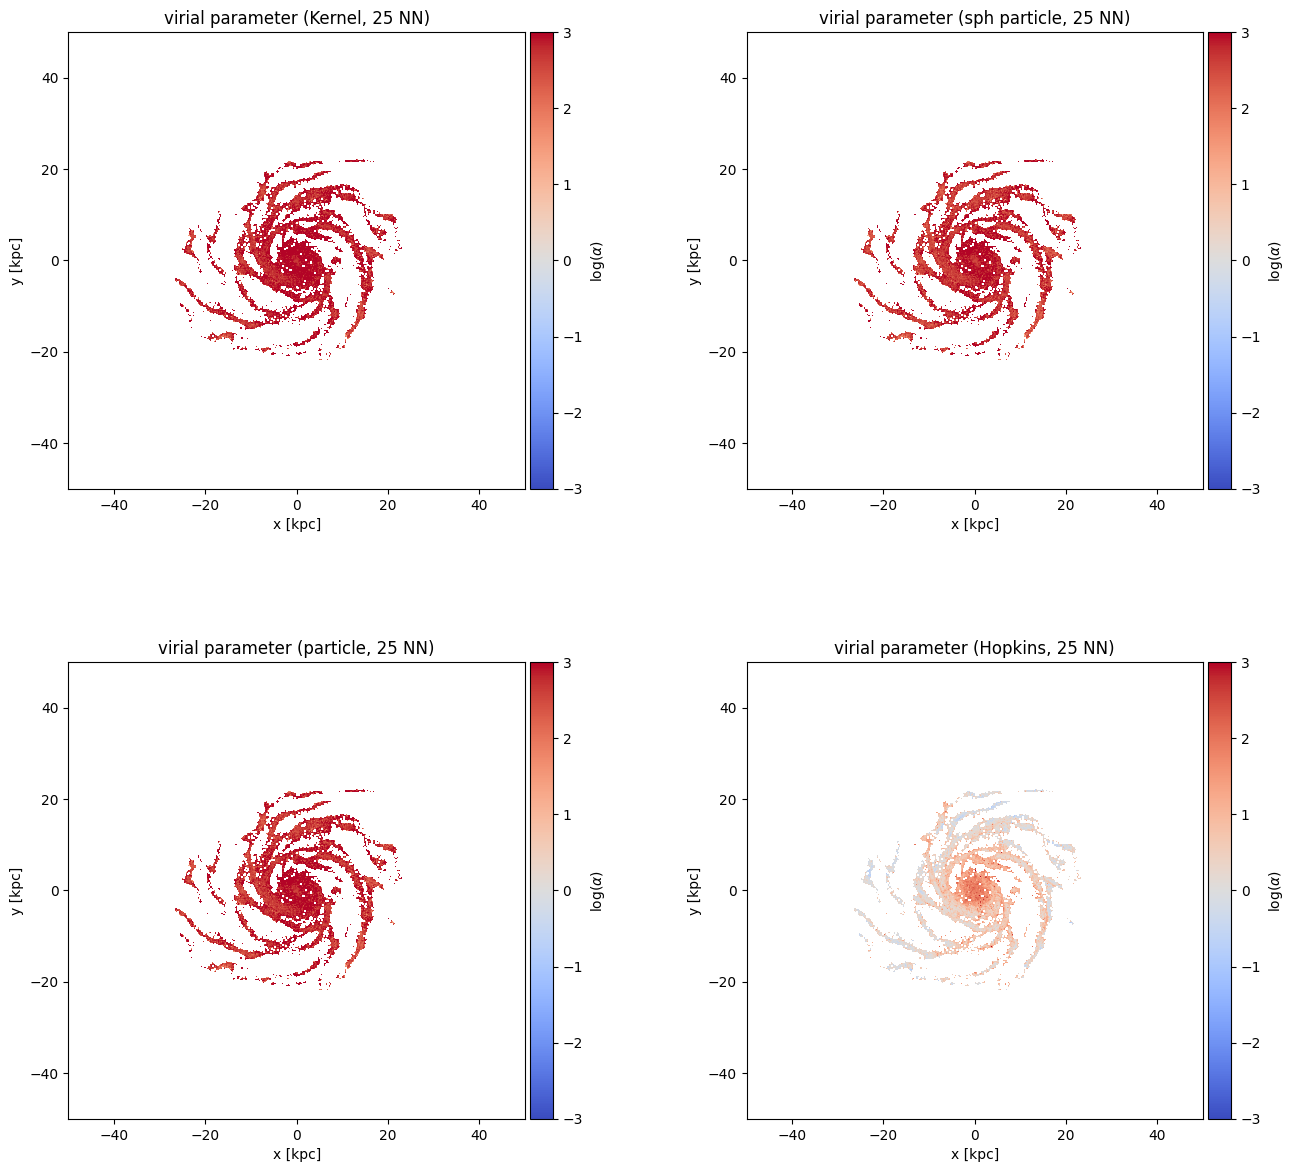

In [73]:
title = ['(Kernel, 25 NN)', '(sph particle, 25 NN)', '(particle, 25 NN)', '(Hopkins, 25 NN)']
alpha = [alpha_W_25, alpha2_W_25, alpha3_W_25, alpha4_W_25]
fig = plt.figure(figsize = (15,15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(4):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, alpha[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = -3, vmax = 3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\alpha$)')
    ax.set_title('virial parameter ' + title[n])
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    #ax.set_xlim(-50, 50)
    #ax.set_ylim(-50, 50)
    ax.set_aspect(1./ax.get_data_ratio())

fig.tight_layout()
plt.show()

/tmp/ipykernel_9570/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass
/tmp/ipykernel_9570/565063234.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


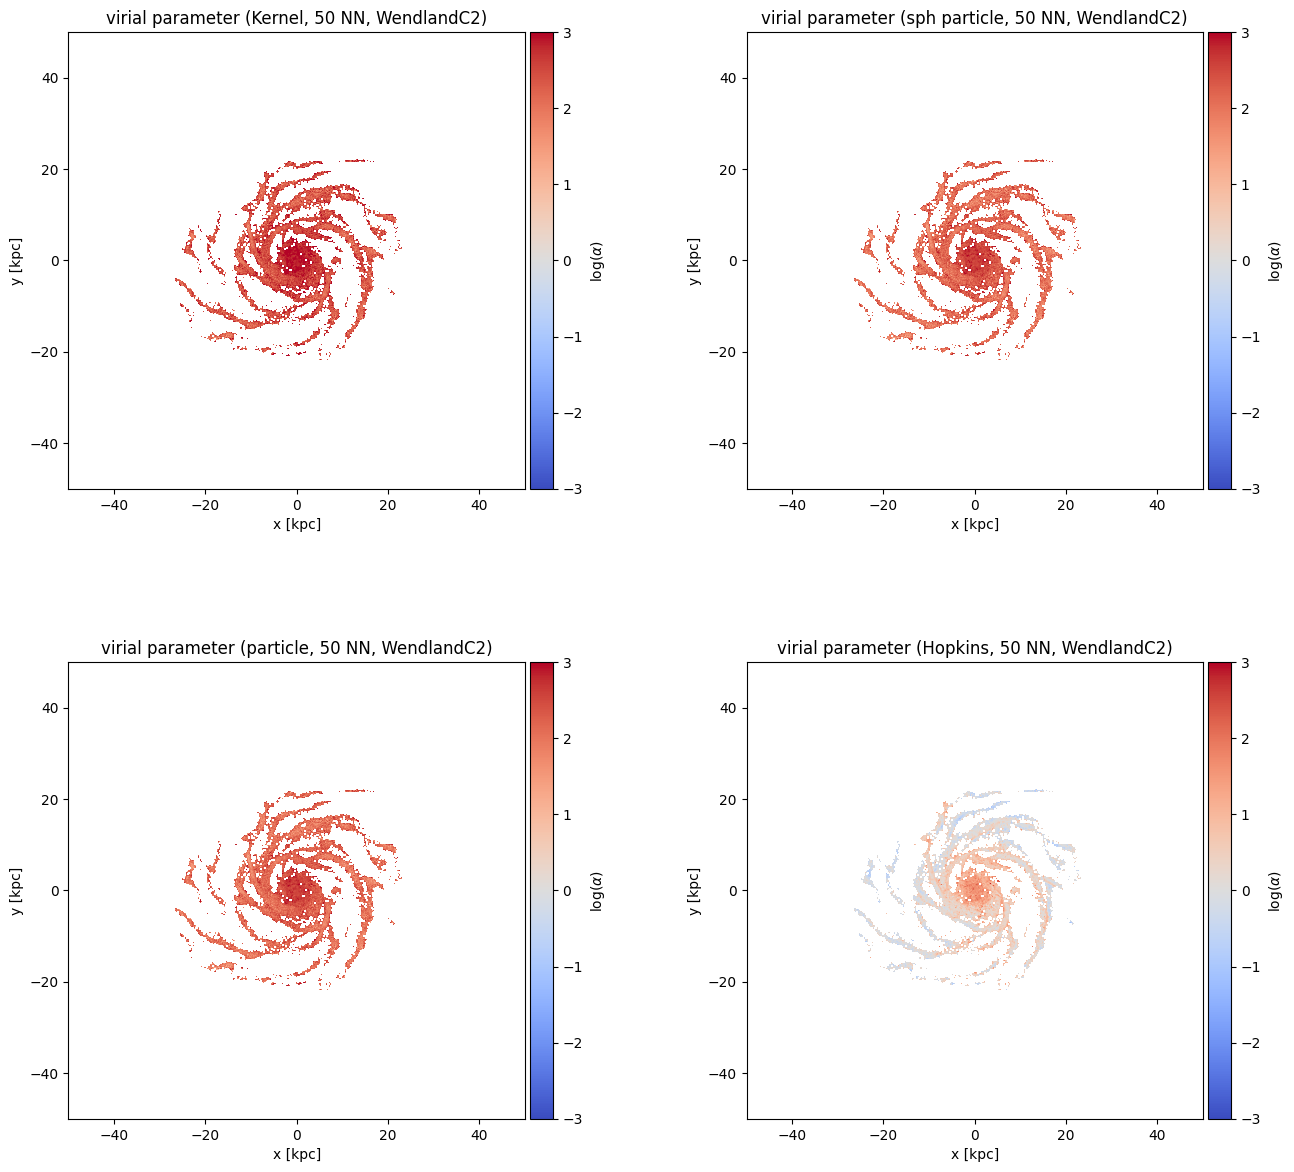

In [78]:
title = ['(Kernel, 50 NN, WendlandC2)', '(sph particle, 50 NN, WendlandC2)', '(particle, 50 NN, WendlandC2)', '(Hopkins, 50 NN, WendlandC2)']
alpha = [alpha_W_50, alpha2_W_50, alpha3_W_50, alpha4_W_50]
fig = plt.figure(figsize = (15,15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(4):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, alpha[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = -3, vmax = 3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\alpha$)')
    ax.set_title('virial parameter ' + title[n])
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    #ax.set_xlim(-50, 50)
    #ax.set_ylim(-50, 50)
    ax.set_aspect(1./ax.get_data_ratio())

fig.tight_layout()
plt.show()

/tmp/ipykernel_9570/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass
/tmp/ipykernel_9570/2514582510.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


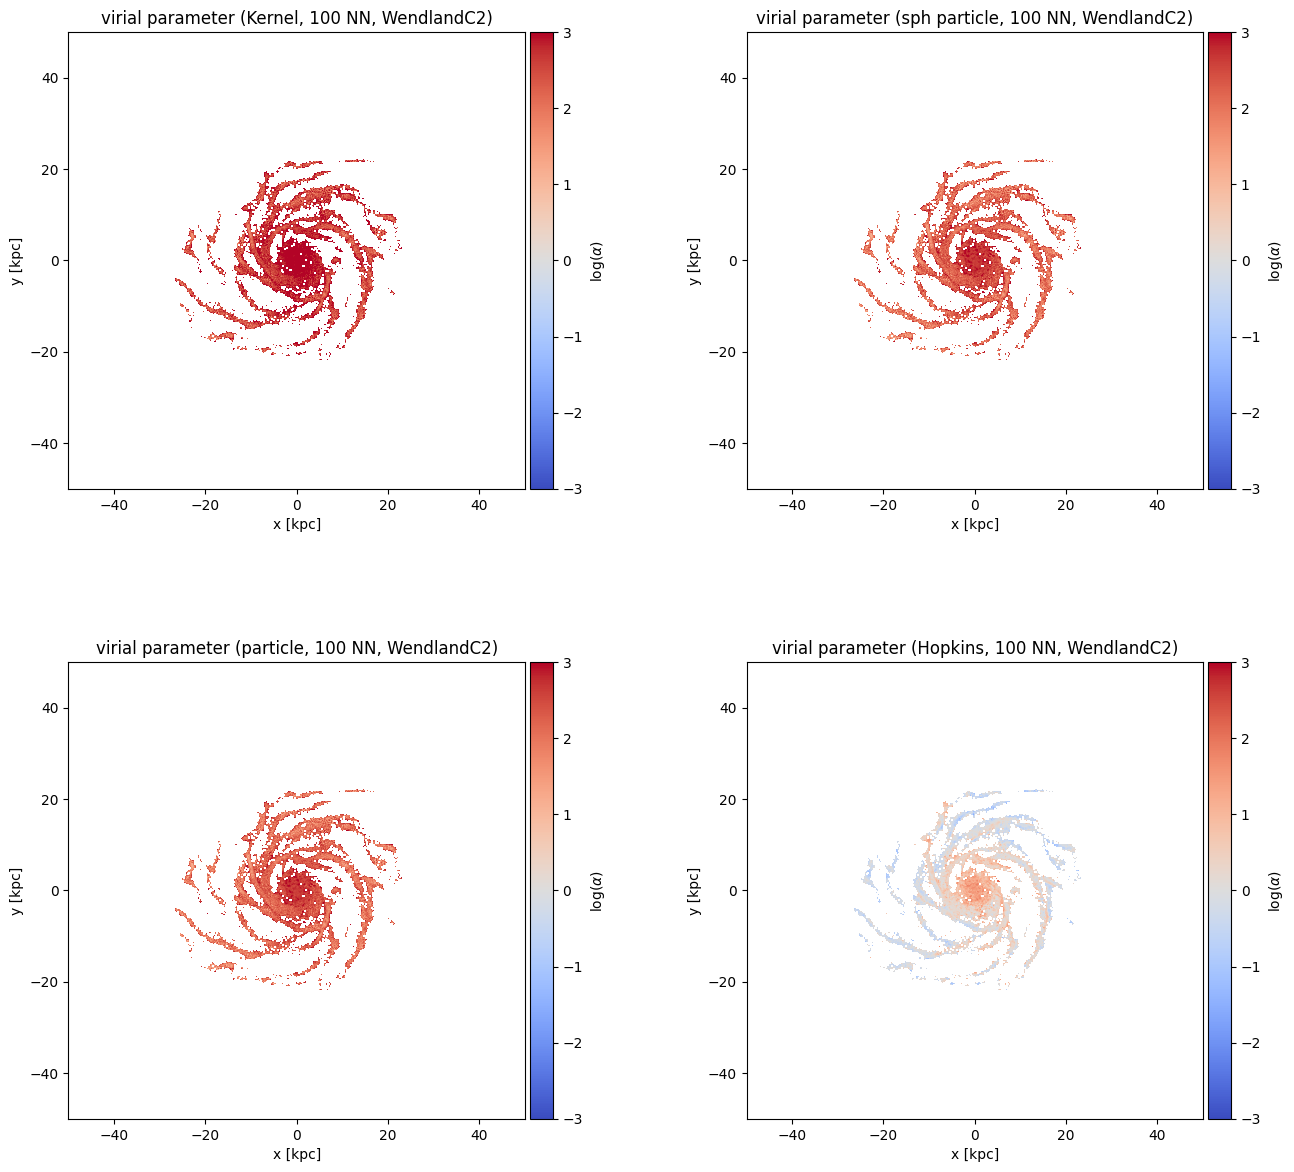

In [76]:
title = ['(Kernel, 100 NN, WendlandC2)', '(sph particle, 100 NN, WendlandC2)', '(particle, 100 NN, WendlandC2)', '(Hopkins, 100 NN, WendlandC2)']
alpha = [alpha_W_100, alpha2_W_100, alpha3_W_100, alpha4_W_100]
fig = plt.figure(figsize = (15,15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(4):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, alpha[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = -3, vmax = 3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\alpha$)')
    ax.set_title('virial parameter ' + title[n])
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    #ax.set_xlim(-50, 50)
    #ax.set_ylim(-50, 50)
    ax.set_aspect(1./ax.get_data_ratio())

fig.tight_layout()
plt.show()

/tmp/ipykernel_9570/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass
/tmp/ipykernel_9570/2906881368.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


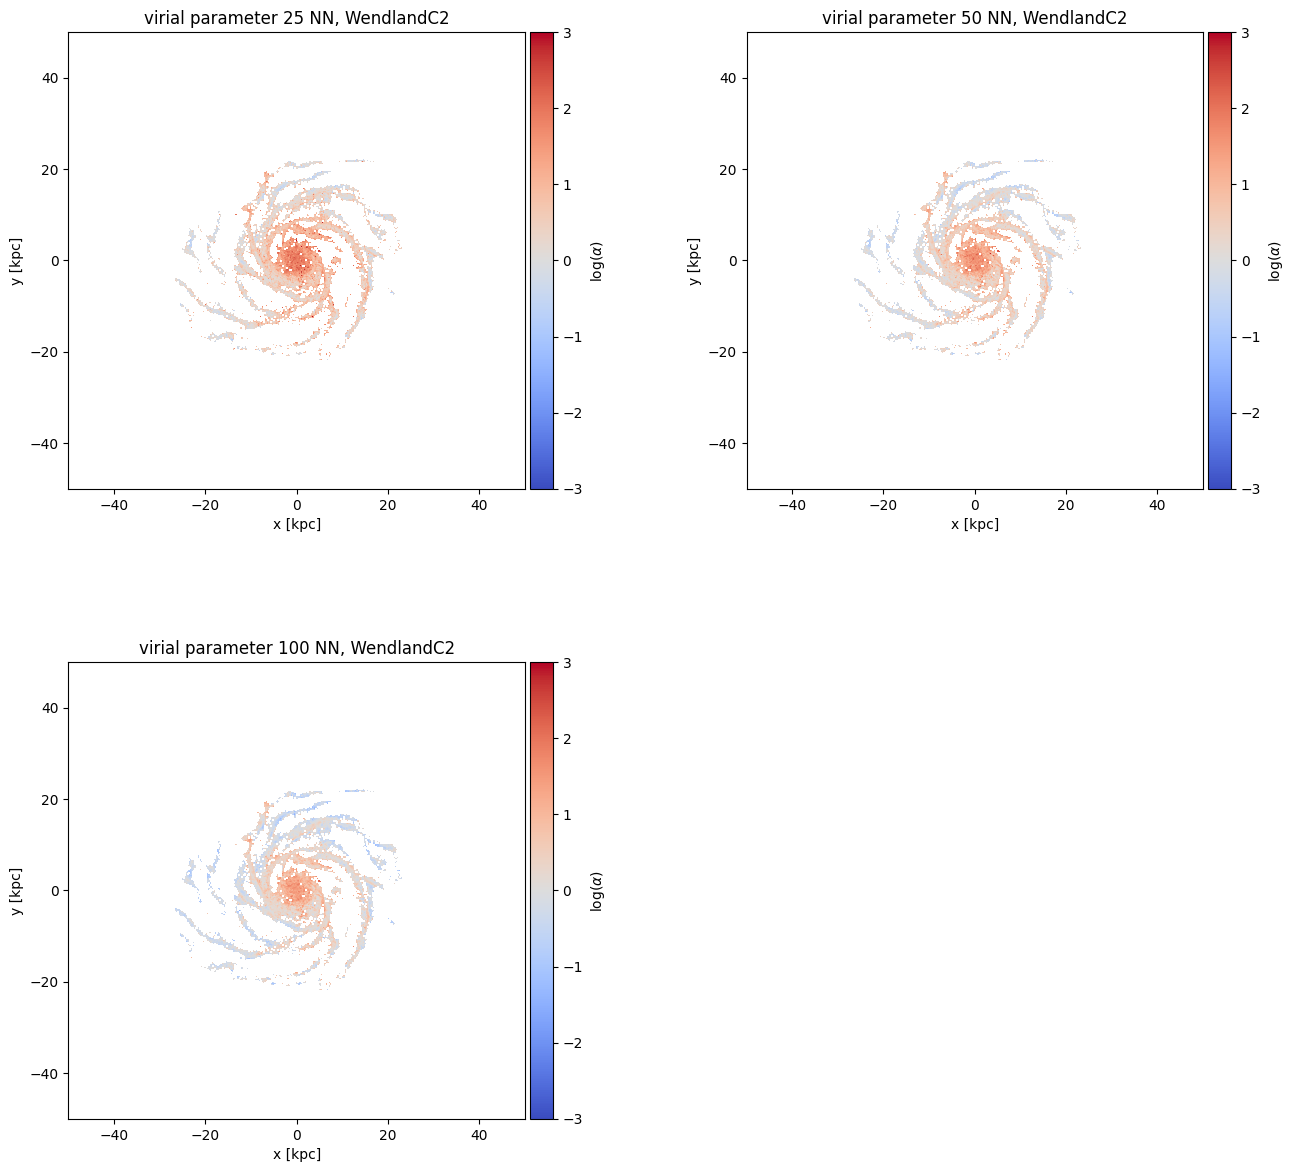

In [77]:
title = ['25 NN, WendlandC2', '50 NN, WendlandC2', '100 NN, WendlandC2']
alpha = [alpha4_W_25, alpha4_W_50, alpha4_W_100]
fig = plt.figure(figsize = (15,15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(3):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, alpha[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = -3, vmax = 3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\alpha$)')
    ax.set_title('virial parameter ' + title[n])
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    #ax.set_xlim(-50, 50)
    #ax.set_ylim(-50, 50)
    ax.set_aspect(1./ax.get_data_ratio())

fig.tight_layout()
plt.show()

/tmp/ipykernel_9570/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass
/tmp/ipykernel_9570/1952549040.py:8: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(mw_hist(gal.g, eff[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = -4)
/tmp/ipykernel_9570/1952549040.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


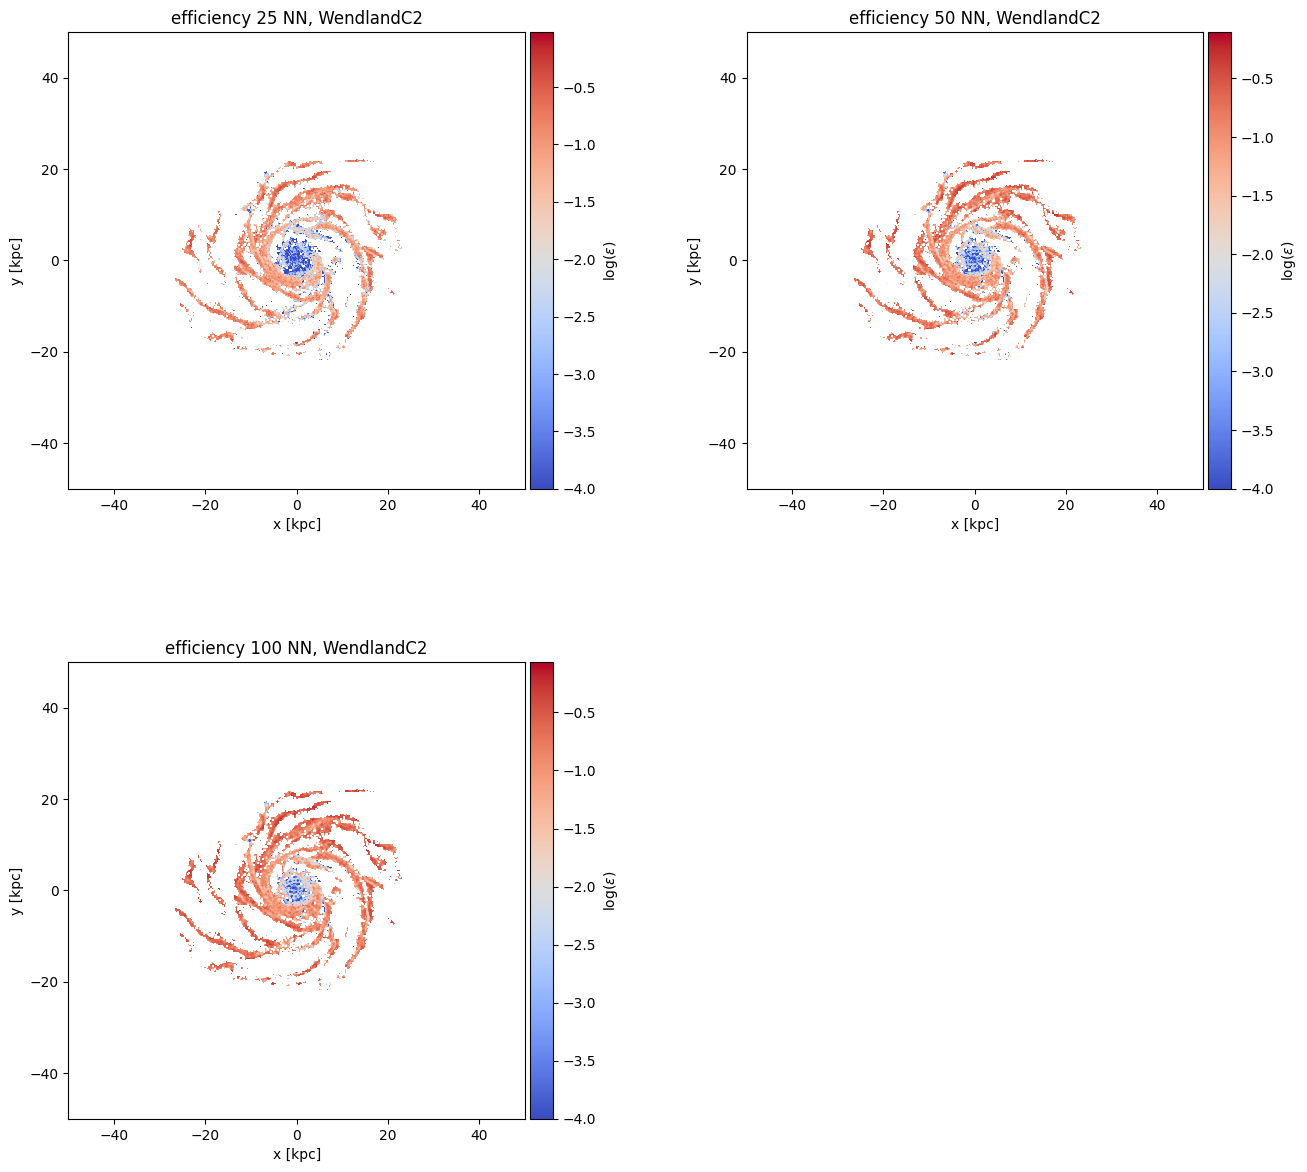

In [84]:
title = ['25 NN, WendlandC2', '50 NN, WendlandC2', '100 NN, WendlandC2']
eff = [eff_W_25, eff_W_50, eff_W_100]
fig = plt.figure(figsize = (15,15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(3):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, eff[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = -4)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\epsilon$)')
    ax.set_title('efficiency ' + title[n])
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    #ax.set_xlim(-50, 50)
    #ax.set_ylim(-50, 50)
    ax.set_aspect(1./ax.get_data_ratio())

fig.tight_layout()
plt.show()

In [24]:
# densities
#g_hist, g_xbins, g_ybins = np.histogram2d(gal.g['x'],gal.g['y'],weights=gal.g['rho'], bins=500, range=((-50,50),(-50,50)))
#s_hist, s_xbins, s_ybins = np.histogram2d(gal.s['x'],gal.s['y'],weights=gal.s['rho'], bins=500, range=((-50,50),(-50,50)))
g_hist, g_xedge, g_yedge, g_bin  = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['rho'], statistic = 'mean', bins = 500)
s_hist, s_xedge, s_yedge, s_bin = stats.binned_statistic_2d(gal.s['x'],gal.s['y'], gal.s['rho'], statistic = 'mean', bins = 500)

alpha_hist, a_xbins, a_ybins, a_bin = stats.binned_statistic_2d(gal_low_alpha['x'],gal_low_alpha['y'], gal_low_alpha['alpha'], statistic = 'mean', bins = 200)
eff_hist, e_xedges, e_yedges, e_bin = stats.binned_statistic_2d(gal_low_alpha['x'],gal_low_alpha['y'], gal_low_alpha['efficiency'], statistic = 'mean', bins = 200)




In [ ]:
pg1 = pynbody.analysis.profile.Profile(gal.g, min = 0.01, max = 50, type = 'equaln')
ps1 = pynbody.analysis.profile.Profile(gal.s, min = 0.01, max = 50, type = 'equaln')
pg_low_alpha = pynbody.analysis.profile.Profile(gal_low_alpha, min = 0.01, max = 50, type = 'equaln')
pg_low_alpha_4 = pynbody.analysis.profile.Profile(gal_low_alpha_4, min = 0.01, max = 50, type = 'equaln')

In [ ]:

fig = plt.figure(figsize = (10,10))

ax1 = plt.subplot(121)
im1 = ax1.imshow(g_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
ax1.imshow(g_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = '$\Sigma$ [M$_\odot$/kpc$^2$]')
ax1.set_title('gas density')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')

ax2 = plt.subplot(122)
im2 = ax2.imshow(s_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
ax2.imshow(s_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = '$\Sigma$ [M$_\odot$/kpc$^2$]')
ax2.set_title('star density')
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('y [kpc]')
#ax1.xlim(-30, 30)
#ax1.ylim(-30,30)

fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize = (15,10))

ax1 = plt.subplot(231)
im1 = ax1.imshow(np.log10(g_hist), cmap='RdYlBu_r', extent=(-50,50,-50,50), vmin = 6.5)
ax1.imshow(np.log10(g_hist), cmap='RdYlBu_r', extent=(-50,50,-50,50), vmin = 6.5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = 'log($\Sigma$) [M$_\odot$/kpc$^2$]')
ax1.set_title('gas density')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
ax1.set_xlim(-20, 20)
ax1.set_ylim(-20,20)

ax2 = plt.subplot(232)
im2 = ax2.imshow(np.log10(mw_hist(gal.g,'temp',500)), cmap='seismic', extent=(-50,50,-50,50))
ax2.imshow(mw_hist(gal.g,'temp',500), cmap='seismic', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = 'T [K]')
ax2.set_title('gas temperature')
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('y [kpc]')
ax2.set_xlim(-20, 20)
ax2.set_ylim(-20,20)

ax3 = plt.subplot(233)
im3 = ax3.imshow(mw_hist(gal.g,'v_disp',500), cmap='gnuplot2', extent=(-50,50,-50,50), vmin = 15, vmax = 70)
ax3.imshow(mw_hist(gal.g,'v_disp',500), cmap='gnuplot2', extent=(-50,50,-50,50), vmin = 15,vmax = 70)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label =r'$\sigma$ [km/s]')
ax3.set_title('Velocity dispersion')
ax3.set_xlabel('x [kpc]')
ax3.set_ylabel('y [kpc]')
ax3.set_aspect('equal')
ax3.set_xlim(-20, 20)
ax3.set_ylim(-20,20)

ax4 = plt.subplot(234)
im4 = ax4.imshow(mw_hist(gal_low_alpha,'alpha_4',500), extent=(-50,50,-50,50), cmap='bone', norm = colors.LogNorm())
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label = r'$\alpha$')
ax4.set_title('Virial parameter')
ax4.set_xlabel('x [kpc]')
ax4.set_ylabel('y [kpc]')
ax4.set_aspect('equal')
ax4.set_xlim(-20, 20)
ax4.set_ylim(-20, 20)

ax5 = plt.subplot(235)
im5 = ax5.imshow(mw_hist(gal_low_alpha,'efficiency',500), extent=(-50,50,-50,50), cmap='gist_earth_r', norm = colors.LogNorm())
ax5.imshow(mw_hist(gal_low_alpha,'efficiency',500), extent=(-50,50,-50,50), cmap='gist_earth_r', norm = colors.LogNorm())
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax, orientation='vertical', label = r'$\epsilon_{ff}$')
ax5.set_title('Efficiency')
ax5.set_xlabel('x [kpc]')
ax5.set_ylabel('y [kpc]')
ax5.set_aspect('equal')
ax5.set_xlim(-20, 20)
ax5.set_ylim(-20,20)


fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize = (12,8))

ax1 = plt.subplot(231)
ax1.plot(pg1['rbins'],pg1['density'])
ax1.semilogy()
ax1.set_title('density')
ax1.set_xlabel('R [kpc]')
ax1.set_ylabel('$\Sigma$ [M$_\odot$/kpc$^2$]')
ax1.grid(linewidth = 0.5)
ax1.set_aspect(1./ax1.get_data_ratio())
#ax1.set_xlim(0,50)
#ax1.set_aspect('equal')

ax2 = plt.subplot(232)
ax2.plot(pg1['rbins'], pg1['temp'])
ax2.set_title('gas temperature')
ax2.set_xlabel('R [kpc]')
ax2.set_ylabel('T [K]')
ax2.grid(linewidth = 0.5)
ax2.set_aspect(1./ax2.get_data_ratio())
#ax2.set_xlim(0,50)
#ax2.set_aspect('equal')

ax3 = plt.subplot(233)
ax3.plot(pg1['rbins'], pg1['v_disp'])
ax3.set_title('velocity dispersion')
ax3.set_xlabel('R [kpc]')
ax3.set_ylabel(r'$\sigma$ [km/s]')
ax3.grid(linewidth = 0.5)
ax3.set_aspect(1./ax3.get_data_ratio())
#ax3.set_xlim(0,50)
#ax3.set_aspect('equal')

ax4 = plt.subplot(234)
ax4.plot(pg_low_alpha['rbins'], pg_low_alpha_4['alpha_4'])
ax4.set_title('virial parameter')
ax4.set_xlabel('R [kpc]')
ax4.set_ylabel(r'$\alpha$')
ax4.grid(linewidth = 0.5)
ax4.set_aspect(1./ax4.get_data_ratio())
#ax4.set_xlim(0,50)
#ax4.set_aspect('equal')

ax5 = plt.subplot(235)
ax5.plot(pg_low_alpha['r'], pg_low_alpha['efficiency'])
ax5.set_title('efficiency')
ax5.set_xlabel('R [kpc]')
ax5.set_ylabel(r'$\epsilon_{ff}$')
ax5.grid(linewidth = 0.5)
ax5.set_aspect(1./ax5.get_data_ratio())
#ax4.set_xlim(0,50)
#ax4.set_aspect('equal')


fig.tight_layout()
plt.show()

In [ ]:
plt.hist2d(gal.g['x'], gal.g['y'], cmap = 'gist_earth', bins = 500)
axes = plt.gca()
axes.set_aspect(1./axes.get_data_ratio())
plt.colorbar()
plt.xlim(-50,50)
plt.ylim(-50,50)


In [ ]:
#2d histogramme von der anzahl -> boxgröße bestimmen, so dass wir 50 teilchen pro box haben-> daraus die größen bestimmen und damit alpha plotten
print(np.mean(hist[hist>0]))

dx = (gal.g['x'].max()-gal.g['x'].min())/250
dy = (gal.g['y'].max()-gal.g['y'].min())/250
dz = gal.g['z'].max()-gal.g['z'].min()
R = 1/2*np.sqrt(dx**2+dy**2+dz**2)

gal.g['velo2'] = gal.g['v_disp']
gal.g['velo2'] = gal.g['v2']**(1/2)
gal.g['velo2']

mass_hist, mass_xedge, mass_yedge, mass_bin = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['mass'], statistic = 'sum', bins=250)
vdisp_hist, vdisp_xedge, vdisp_yedge, vdisp_bin = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['velo2'], statistic = 'std', bins=250)

a_hist = np.zeros((250,250))
for i in range(250):
    for j in range(250):
        a_hist[i][j] = 5*(vdisp_hist[i][j]*units.km*units.s**-1)**2*R/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*mass_hist[i][j]*units.Msol)

In [ ]:
def binstat(fam, key, b):
    stat, edges, num = stats.binned_statistic(fam['r'], fam[key]*fam['mass'], statistic = sum, bins = b)
    stat_mass, edges_mass, num_mass = stats.binned_statistic(fam['r'], fam['mass'], statistic = sum, bins = b)
    return stat/stat_mass, edges[:-1]